In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

## Common setup

In [22]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [4]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [5]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.346650	Accuracy: 10.9375
Train: [12800/60000 (21%)]	Loss: 3.077266	Accuracy: 14.981617647058824
Train: [25600/60000 (43%)]	Loss: 1.697788	Accuracy: 24.934251237623762
Train: [38400/60000 (64%)]	Loss: 1.079904	Accuracy: 36.44971026490066
Train: [51200/60000 (85%)]	Loss: 0.635252	Accuracy: 47.97885572139303
Epoch: 1/20. Train set: Average loss: 1.4530	Accuracy: 54.07
Epoch: 1/20. Validation set: Average loss: 0.4105	Accuracy: 89.78
Train: [0/60000 (0%)]	Loss: 0.293211	Accuracy: 91.40625
Train: [12800/60000 (21%)]	Loss: 0.356806	Accuracy: 92.07261029411765
Train: [25600/60000 (43%)]	Loss: 0.268208	Accuracy: 93.17373143564356
Train: [38400/60000 (64%)]	Loss: 0.232629	Accuracy: 93.7603476821192
Train: [51200/60000 (85%)]	Loss: 0.232062	Accuracy: 94.1561722636816
Epoch: 2/20. Train set: Average loss: 0.2607	Accuracy: 94.43666666666667
Epoch: 2/20. Validation set: Average loss: 0.1417	Accuracy: 97.0
Train: [0/60000 (0%)]	Loss: 0.207692	Accuracy: 96.09375
Train: [

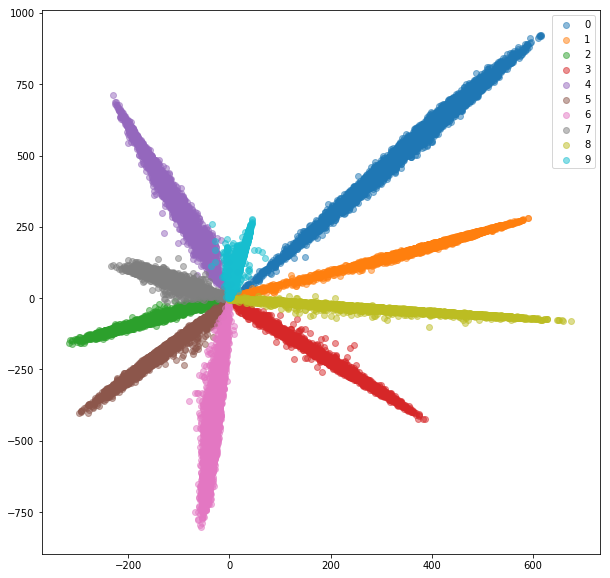

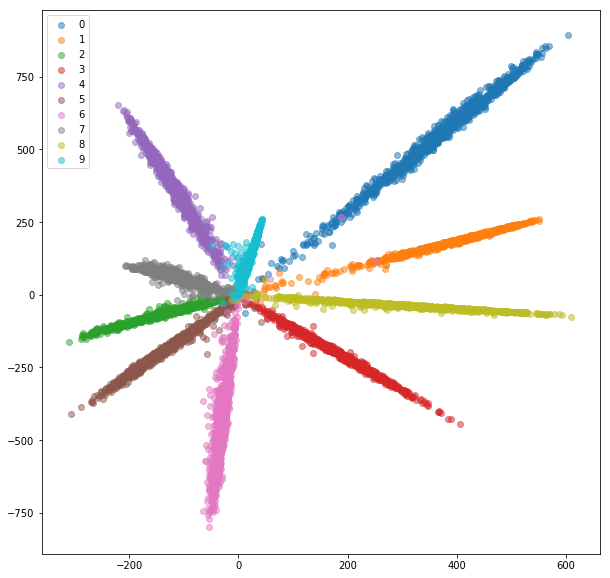

In [6]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [7]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [8]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.231194
Train: [12800/60000 (21%)]	Loss: 0.066589
Train: [25600/60000 (43%)]	Loss: 0.038167
Train: [38400/60000 (64%)]	Loss: 0.028319
Train: [51200/60000 (85%)]	Loss: 0.023964
Epoch: 1/20. Train set: Average loss: 0.0371
Epoch: 1/20. Validation set: Average loss: 0.0211
Train: [0/60000 (0%)]	Loss: 0.026424
Train: [12800/60000 (21%)]	Loss: 0.018559
Train: [25600/60000 (43%)]	Loss: 0.017005
Train: [38400/60000 (64%)]	Loss: 0.013612
Train: [51200/60000 (85%)]	Loss: 0.013576
Epoch: 2/20. Train set: Average loss: 0.0153
Epoch: 2/20. Validation set: Average loss: 0.0127
Train: [0/60000 (0%)]	Loss: 0.007043
Train: [12800/60000 (21%)]	Loss: 0.011907
Train: [25600/60000 (43%)]	Loss: 0.010600
Train: [38400/60000 (64%)]	Loss: 0.009102
Train: [51200/60000 (85%)]	Loss: 0.009029
Epoch: 3/20. Train set: Average loss: 0.0100
Epoch: 3/20. Validation set: Average loss: 0.0095
Train: [0/60000 (0%)]	Loss: 0.011841
Train: [12800/60000 (21%)]	Loss: 0.008350
Train: [25600/60000 (

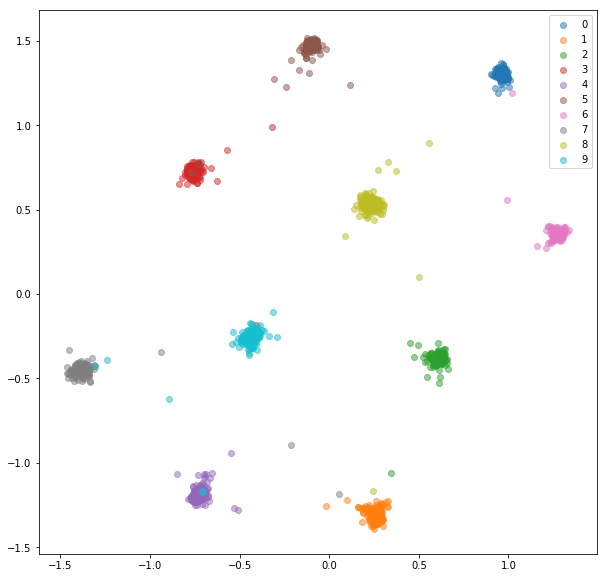

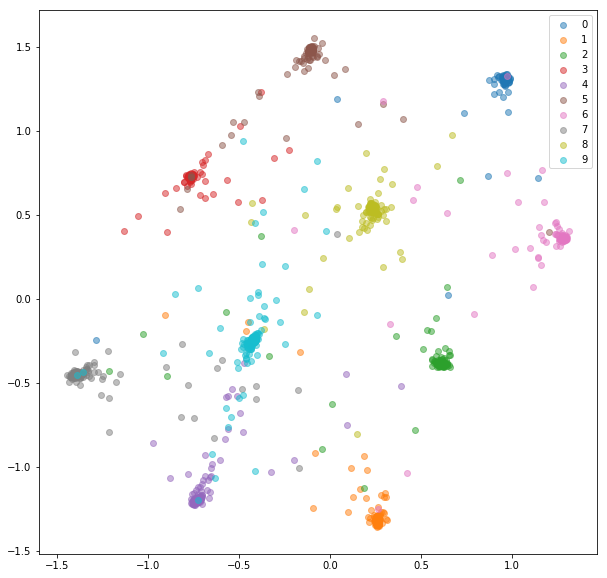

In [9]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [10]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [11]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999007
Train: [12800/60000 (21%)]	Loss: 0.274871
Train: [25600/60000 (43%)]	Loss: 0.133373
Train: [38400/60000 (64%)]	Loss: 0.091401
Train: [51200/60000 (85%)]	Loss: 0.076189
Epoch: 1/20. Train set: Average loss: 0.1369
Epoch: 1/20. Validation set: Average loss: 0.0760
Train: [0/60000 (0%)]	Loss: 0.048056
Train: [12800/60000 (21%)]	Loss: 0.063338
Train: [25600/60000 (43%)]	Loss: 0.044140
Train: [38400/60000 (64%)]	Loss: 0.047801
Train: [51200/60000 (85%)]	Loss: 0.048939
Epoch: 2/20. Train set: Average loss: 0.0507
Epoch: 2/20. Validation set: Average loss: 0.0372
Train: [0/60000 (0%)]	Loss: 0.080776
Train: [12800/60000 (21%)]	Loss: 0.036223
Train: [25600/60000 (43%)]	Loss: 0.034145
Train: [38400/60000 (64%)]	Loss: 0.029734
Train: [51200/60000 (85%)]	Loss: 0.030993
Epoch: 3/20. Train set: Average loss: 0.0322
Epoch: 3/20. Validation set: Average loss: 0.0349
Train: [0/60000 (0%)]	Loss: 0.008302
Train: [12800/60000 (21%)]	Loss: 0.032861
Train: [25600/60000 (

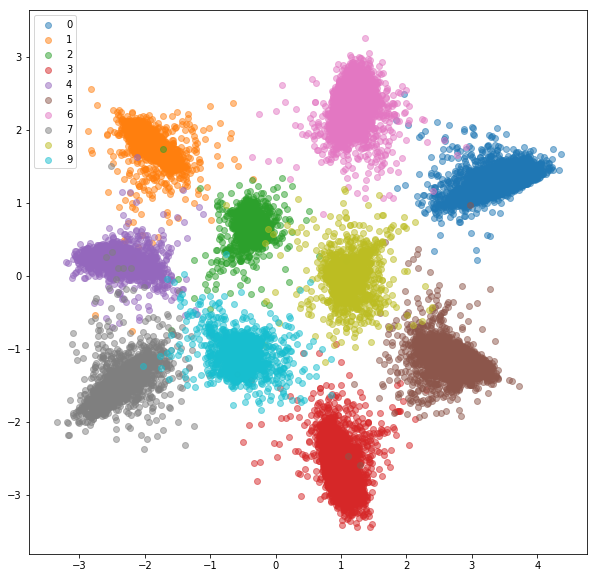

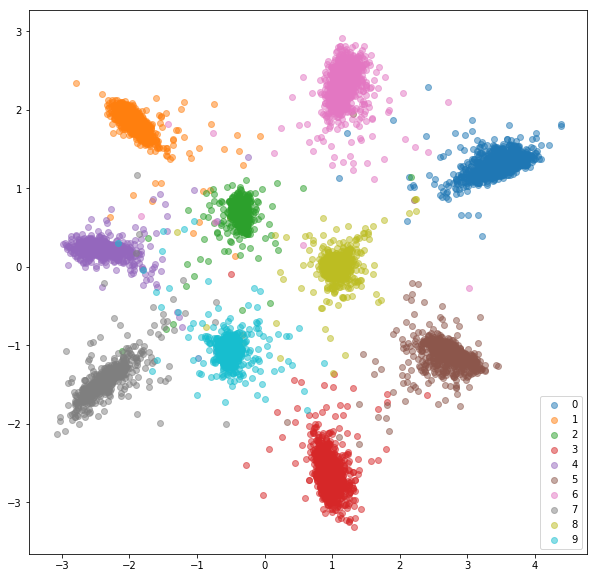

In [12]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection

In [19]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [20]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.491782
Train: [12500/60000 (21%)]	Loss: 0.307306
Train: [25000/60000 (42%)]	Loss: 0.176746
Train: [37500/60000 (62%)]	Loss: 0.123000
Train: [50000/60000 (83%)]	Loss: 0.101276
Epoch: 1/20. Train set: Average loss: 0.1624
Epoch: 1/20. Validation set: Average loss: 0.0712
Train: [0/60000 (0%)]	Loss: 0.105720
Train: [12500/60000 (21%)]	Loss: 0.064737
Train: [25000/60000 (42%)]	Loss: 0.059181
Train: [37500/60000 (62%)]	Loss: 0.052044
Train: [50000/60000 (83%)]	Loss: 0.048578
Epoch: 2/20. Train set: Average loss: 0.0556
Epoch: 2/20. Validation set: Average loss: 0.0397
Train: [0/60000 (0%)]	Loss: 0.042087
Train: [12500/60000 (21%)]	Loss: 0.035919
Train: [25000/60000 (42%)]	Loss: 0.038345
Train: [37500/60000 (62%)]	Loss: 0.036869
Train: [50000/60000 (83%)]	Loss: 0.037709
Epoch: 3/20. Train set: Average loss: 0.0360
Epoch: 3/20. Validation set: Average loss: 0.0378
Train: [0/60000 (0%)]	Loss: 0.031000
Train: [12500/60000 (21%)]	Loss: 0.027174
Train: [25000/60000 (

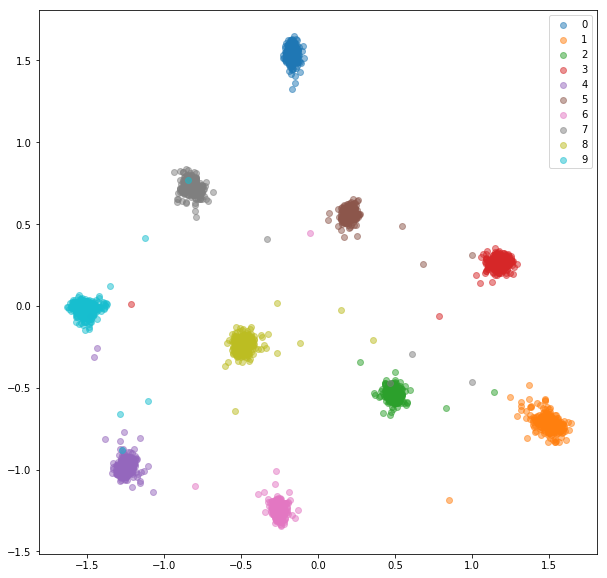

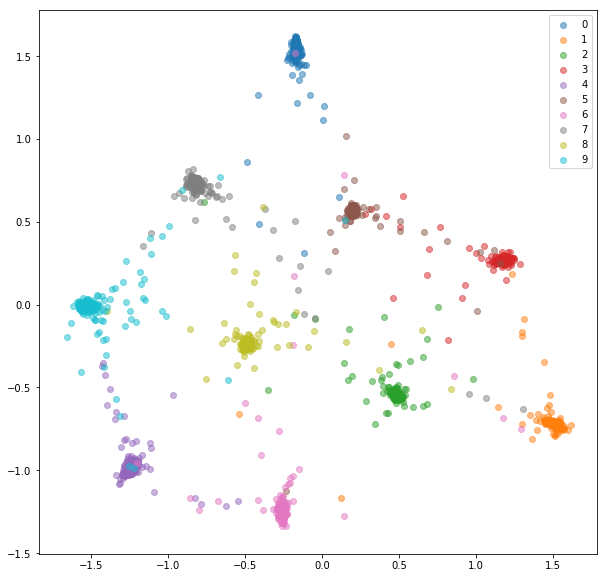

In [21]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection

In [16]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [17]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999229	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.980307	Average nonzero triplets: 2667.4901960784314
Train: [25000/60000 (42%)]	Loss: 0.966596	Average nonzero triplets: 2330.871287128713
Train: [37500/60000 (62%)]	Loss: 0.964447	Average nonzero triplets: 2078.1258278145697
Train: [50000/60000 (83%)]	Loss: 0.976573	Average nonzero triplets: 1903.273631840796
Epoch: 1/20. Train set: Average loss: 0.9763	Average nonzero triplets: 1773.1338912133892
Epoch: 1/20. Validation set: Average loss: 0.9447	Average nonzero triplets: 1102.923076923077
Train: [0/60000 (0%)]	Loss: 1.196839	Average nonzero triplets: 1257.0
Train: [12500/60000 (21%)]	Loss: 0.993427	Average nonzero triplets: 1221.9607843137255
Train: [25000/60000 (42%)]	Loss: 1.019252	Average nonzero triplets: 1178.2376237623762
Train: [37500/60000 (62%)]	Loss: 1.086292	Average nonzero triplets: 1084.794701986755
Train: [50000/60000 (83%)]	Loss: 1.011965	Average nonzero triplets: 10

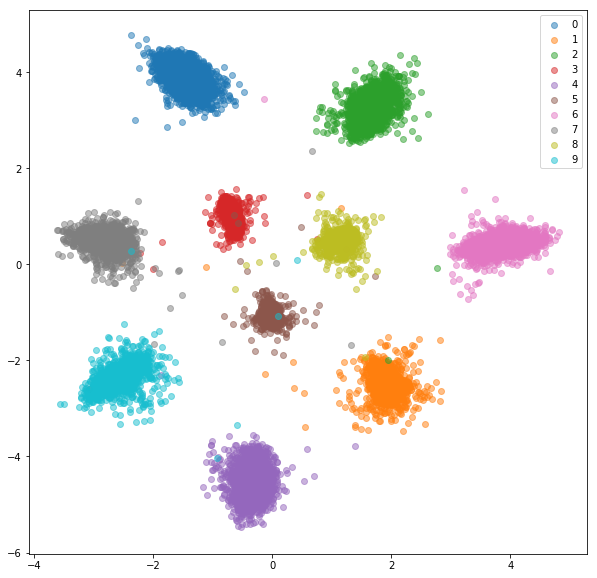

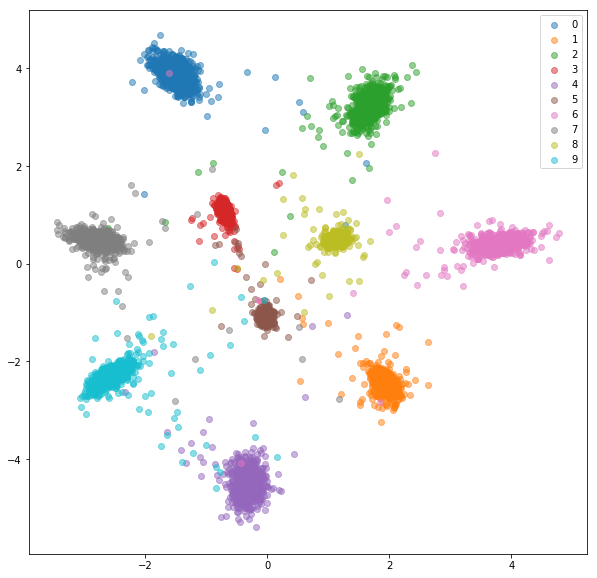

In [18]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

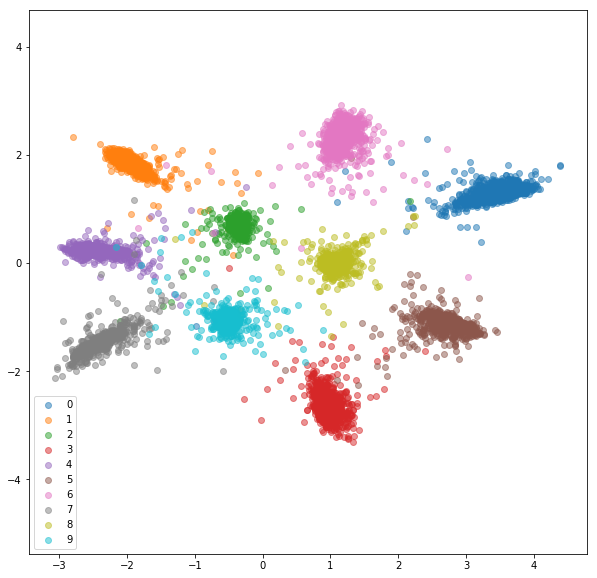

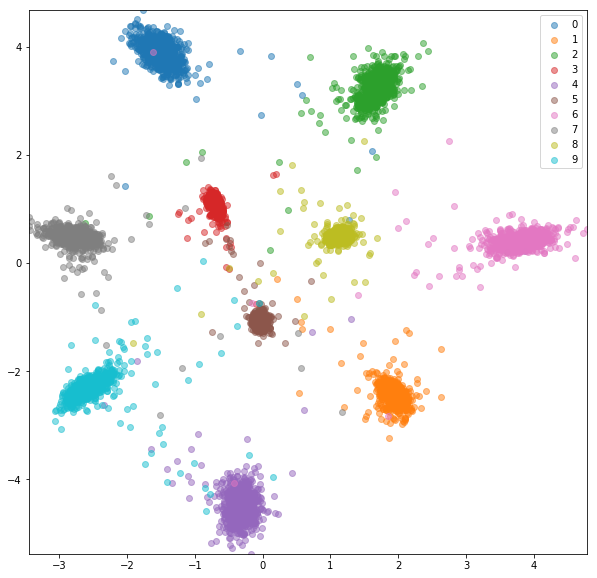

In [32]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

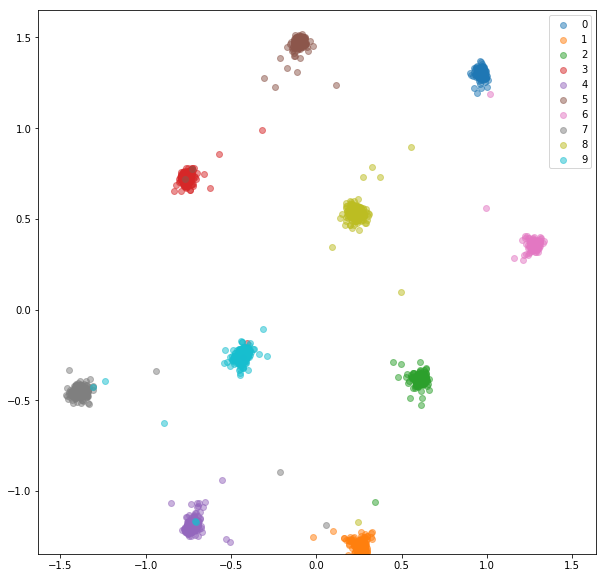

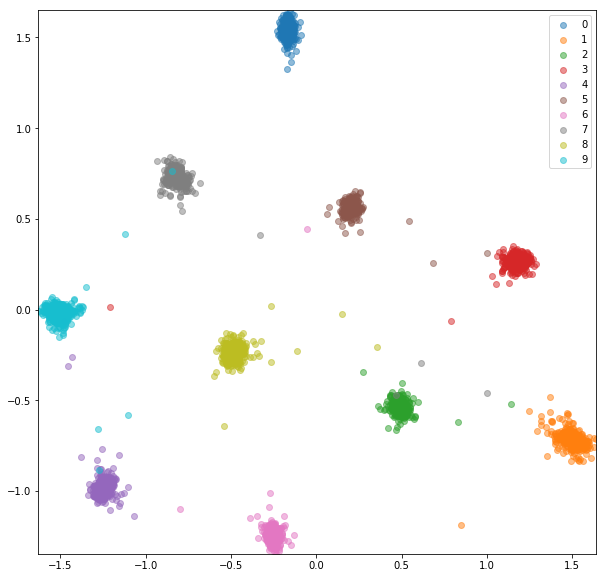

In [28]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)